In [2]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation
import random

I suspect that if you have a 16x16 fine level lattice, the Gibbs sampler will be struggling on the 8x8 coarse level lattice due to the strong autocorrelations. You could do more Gibbs steps on the coarse level and see if that helps. Maybe initially do 10 Gibbs steps, but then increase this further to, say, 100 to see if that makes a difference. The other thing you could try is to do *no* Gibbs step on the coarse level, and just copy over the configuration. This is obviously wrong, but you should get 100% acceptance. You could also look at the individual contributions to the difference in the actions and check what makes \delta S large. \Delta S is the sum of six terms, coming from the different parts of the acceptance ratio.

In [3]:
beta_c = 0.5 * math.log(1+2**0.5)

In [4]:
def config_gen(N):
    """ A function to generate a random configuration of the Ising 
        Model of size N by N"""
    matrix = np.random.randint(2, size=(N,N))
    config = np.where(matrix == 0, matrix-1, matrix)
    return(config)



def gibbs(config,beta,h):
    """ A function that gives a full gibbs update for the Ising Model 
        given some inverse temperature beta and external magnetic field h"""
    
    N = np.shape(config)[0]
    
    linear_indices = np.asarray(range(N**2),dtype=int)
    random.shuffle(linear_indices)
    lattice_sites = [(ell//N,ell%N) for ell in linear_indices]
    
    for (i,j) in lattice_sites:
        
    # Update spin (i,j) with Gibbs sample
        node = np.array([i,j])
    
        delta = -1*(config[(node[0]+1)%N,node[1]]+config[(node[0]-1)%N,node[1]]+config[node[0],(node[1]+1)%N]+config[node[0],(node[1]-1)%N]+h)
        q = 1/(1+math.exp(2*beta*delta))
    
        #the rejection bit
        U = np.random.uniform()
        if U < q:
            config[node[0],node[1]] = 1
        else:
            config[node[0],node[1]] = -1


# two step with fixed gibbs for the coarse level

In [5]:
def compute_S(config,proposal,beta,h,blue_sites,red_sites):
    
    #now were going to compute just S not exp(S)
    N = np.shape(config)[0]
    
    #full ratio
    config_energy = 0
    proposal_energy = 0
    
    for i in range(N):
        for j in range(N):
            energy_chunk_config = -0.5*config[i,j]*(config[(i+1)%N,j]+config[(i-1)%N,j]+config[i,(j+1)%N]+config[i,(j-1)%N]) - h*config[i,j]
            energy_chunk_proposal = -0.5*proposal[i,j]*(proposal[(i+1)%N,j]+proposal[(i-1)%N,j]+proposal[i,(j+1)%N]+proposal[i,(j-1)%N]) - h*proposal[i,j]
            config_energy = config_energy + energy_chunk_config
            proposal_energy = proposal_energy + energy_chunk_proposal
            
    frac_1 = -beta *(proposal_energy-config_energy)
    #coarse ratio
    coarse_config = config[::2,::2]
    coarse_proposal = proposal[::2,::2]
    
    coarse_config_energy = 0
    coarse_proposal_energy = 0
    coarse_N = int(N/2)
    for i in range(coarse_N):
        for j in range(coarse_N):
            energy_chunk_coarse_config = -0.5*coarse_config[i,j]*(coarse_config[(i+1)%coarse_N,j]+coarse_config[(i-1)%coarse_N,j]+coarse_config[i,(j+1)%coarse_N]+coarse_config[i,(j-1)%coarse_N]) - h*coarse_config[i,j]
            energy_chunk_coarse_proposal = -0.5*coarse_proposal[i,j]*(coarse_proposal[(i+1)%coarse_N,j]+coarse_proposal[(i-1)%coarse_N,j]+coarse_proposal[i,(j+1)%coarse_N]+coarse_proposal[i,(j-1)%coarse_N]) - h*coarse_proposal[i,j]
            coarse_config_energy = coarse_config_energy + energy_chunk_coarse_config
            coarse_proposal_energy = coarse_proposal_energy + energy_chunk_coarse_proposal
            
    frac_4 = -beta *(coarse_config_energy-coarse_proposal_energy)
    
    #blue_ratio
    config_sum_blue = 0
    proposal_sum_blue = 0
    
    for (i,j) in blue_sites:
        config_delta = -1*(config[(i+1)%N,(j+1)%N]+config[(i-1)%N,(j-1)%N]+config[(i-1)%N,(j+1)%N]+config[(i+1)%N,(j-1)%N]+h)
        proposal_delta = -1*(proposal[(i+1)%N,(j+1)%N]+proposal[(i-1)%N,(j-1)%N]+proposal[(i-1)%N,(j+1)%N]+proposal[(i+1)%N,(j-1)%N]+h)
        
        config_sum_blue += np.log(1/(1+np.exp(2*beta*config[i,j]*config_delta)))
        proposal_sum_blue += np.log(1/(1+np.exp(2*beta*proposal[i,j]*proposal_delta))) 
        
    frac_3 = config_sum_blue - proposal_sum_blue
    
    #red ratio
    config_sum_red = 0
    proposal_sum_red = 0
    
    for (i,j) in red_sites:
        config_delta = -1*(config[i,(j+1)%N]+config[i,(j-1)%N]+config[(i-1)%N,j]+config[(i+1)%N,j]+h)
        proposal_delta = -1*(proposal[i,(j+1)%N]+proposal[i,(j-1)%N]+proposal[(i-1)%N,j]+proposal[(i+1)%N,j]+h)
        
        config_sum_red += np.log(1/(1+np.exp(2*beta*config[i,j]*config_delta)))
        proposal_sum_red += np.log(1/(1+np.exp(2*beta*proposal[i,j]*proposal_delta))) 
        
    frac_2 = config_sum_red - proposal_sum_red
    return(frac_1+frac_2+frac_3+frac_4)

In [6]:
def ising_2d_two_step_fixed_gibbs(config,beta,h,gibbs_numbers):
    
    N = np.shape(config)[0]
    proposal = config.copy() #initiate the proposal
    
    #split up the indices
    #full
    linear_indices = np.asarray(range(N**2),dtype=int)
    lattice_sites = [(ell//N,ell%N) for ell in linear_indices]
    #coarse
    coarse_sites = [(i,j) for i in range(0,N,2) for j in range(0,N,2)]
    #blue
    blue_sites = [(i,j) for i in range(1,N,2) for j in range(1,N,2)]
    #red
    red_sites = lattice_sites.copy()
    for i in range(len(blue_sites)):
        red_sites.remove(blue_sites[i])
    for i in range(len(coarse_sites)):
        red_sites.remove(coarse_sites[i])
    
    #sample coarse
    #for now we use a gibbs sampler here
    if (gibbs_numbers>0):
        for i in range(gibbs_numbers):
            gibbs(proposal[::2,::2],beta,h)
    
    #sample blue
    for (i,j) in blue_sites:
        delta = -1*(proposal[(i+1)%N,(j+1)%N]+proposal[(i-1)%N,(j-1)%N]+proposal[(i-1)%N,(j+1)%N]+proposal[(i+1)%N,(j-1)%N]+h)
        q = 1/(1+np.exp(2*beta*delta))
        
        #the rejection bit
        U = np.random.uniform()
        if U < q:
            proposal[i,j] = 1
        else:
            proposal[i,j] = -1
            
    
    #sample red
    for (i,j) in red_sites:
        delta = -1*(proposal[i,(j+1)%N]+proposal[i,(j-1)%N]+proposal[(i-1)%N,j]+proposal[(i+1)%N,j]+h)
        q = 1/(1+math.exp(2*beta*delta))
        
        #the rejection bit
        U = np.random.uniform()
        if U < q:
            proposal[i,j] = 1
        else:
            proposal[i,j] = -1
            
    
    #sample rejection
    S = compute_S(config,proposal,beta,h,blue_sites,red_sites) #computing S - returns -Delta S_ell
    if (-1*S<0):
        sample = proposal.copy()
        info=0
    else:
        U = np.random.uniform()
        if U < np.exp(S):
            sample = proposal.copy()
            info=0
        else:
            sample = config.copy()
            info = 1
            
    return(sample,info)

## Testing stuff

In [10]:
config = config_gen(16)

N_vec = np.array([0,1,10,20,30,40,50])
prob_vec = np.zeros(len(N_vec))

for N in N_vec:
    print('beginning ',N)
    info_sum = 0
    for i in range(10000):
        config,info = ising_2d_two_step_fixed_gibbs(config,beta_c,0,N)
        info_sum += info
        prob_vec[np.where(N_vec == N)] = info_sum/10000
    
    


beginning  0
beginning  1
beginning  10
beginning  20
beginning  30
beginning  40
beginning  50


In [14]:
1-prob_vec

array([0.163, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [1]:
plt.plot(N_vec,1-prob_vec)
#plt.title('N=8')
plt.xlabel('Number of Gibbs Steps')
plt.ylabel('Acceptance probability')
plt.show()

NameError: name 'plt' is not defined

In [94]:
config = config_gen(16)

N_vec = np.array([1,20,40,60,80,100])
prob_vec = np.zeros(6)

for N in N_vec:
    print('beginning ',N)
    info_sum = 0
    for i in range(10000):
        config,info = ising_2d_two_step_fixed_gibbs(config,beta_c,0,N)
        info_sum += info
        prob_vec[np.where(N_vec == N)] = info_sum/10000
    
    



beginning  1
beginning  20
beginning  40
beginning  60
beginning  80
beginning  100


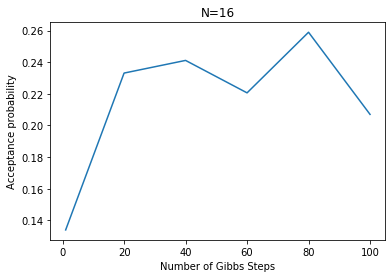

In [95]:
plt.plot(N_vec,1-prob_vec)
plt.title('N=16')
plt.xlabel('Number of Gibbs Steps')
plt.ylabel('Acceptance probability')
plt.show()

In [ ]:
#acceptance rates

In [84]:
N_vec = np.array([6,8,10,12])
iact_vec = np.array([2,4,5,7])
prob_vec = np.zeros(4)
prob_vec_iact = np.zeros(4)

for N in N_vec:
    print('beginning ',N)
    config = config_gen(N)
    config_iact = config.copy()
    info_sum = 0
    info_sum_iact = 0
    for i in range(10000):
        config,info = ising_2d_two_step_fixed_gibbs(config,beta_c,0,1)
        config_iact,info_iact = ising_2d_two_step_fixed_gibbs(config_iact,beta_c,0,int(2*iact_vec[np.where(N_vec == N)]))
    for i in range(10000):
        config,info = ising_2d_two_step_fixed_gibbs(config,beta_c,0,1)
        info_sum += info
        prob_vec[np.where(N_vec == N)] = info_sum/10000
        
        config_iact,info_iact = ising_2d_two_step_fixed_gibbs(config_iact,beta_c,0,int(2*iact_vec[np.where(N_vec == N)]))
        info_sum_iact += info_iact
        prob_vec_iact[np.where(N_vec == N)] = info_sum_iact/10000
        


beginning  6
beginning  8
beginning  10
beginning  12


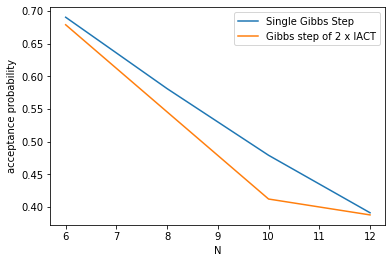

In [85]:
plt.plot( N_vec,1-prob_vec, label = "Single Gibbs Step")
plt.plot( N_vec,1-prob_vec_iact, label = "Gibbs step of 2 x IACT")
plt.xlabel('N')
plt.ylabel('acceptance probability')
plt.legend()
plt.show()

In [88]:
#try again with 20*iact

N_vec = np.array([6,8,10,12])
iact_vec = np.array([2,4,6,7])
prob_vec = np.zeros(4)
prob_vec_iact = np.zeros(4)

for N in N_vec:
    print('beginning ',N)
    config = config_gen(N)
    config_iact = config.copy()
    info_sum = 0
    info_sum_iact = 0
    for i in range(10000):
        config,info = ising_2d_two_step_fixed_gibbs(config,beta_c,0,1)
        config_iact,info_iact = ising_2d_two_step_fixed_gibbs(config_iact,beta_c,0,int(20*iact_vec[np.where(N_vec == N)]))
    for i in range(10000):
        config,info = ising_2d_two_step_fixed_gibbs(config,beta_c,0,1)
        info_sum += info
        prob_vec[np.where(N_vec == N)] = info_sum/10000
        
        config_iact,info_iact = ising_2d_two_step_fixed_gibbs(config_iact,beta_c,0,int(20*iact_vec[np.where(N_vec == N)]))
        info_sum_iact += info_iact
        prob_vec_iact[np.where(N_vec == N)] = info_sum_iact/10000
        



beginning  6
beginning  8
beginning  10
beginning  12


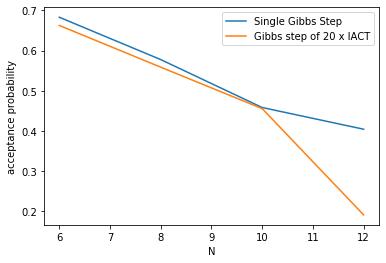

In [90]:
plt.plot( N_vec,1-prob_vec, label = "Single Gibbs Step")
plt.plot( N_vec,1-prob_vec_iact, label = "Gibbs step of 20 x IACT")
plt.xlabel('N')
plt.ylabel('acceptance probability')
plt.legend()
plt.show()

In [124]:
def mc_susceptibility(config_0,beta,h,T,burn_in=0):
    """ A function to sample the magentism for an Ising model with
        a given inverse temp beta and external field h, where T is 
        the number of samples required"""
    
    N = np.shape(config_0)[0]
    
    mu = 0
    mu_2 = 0
    mu_4 = 0
    
    current_config = config_0
    rejection = 0
    info_vec = []
    
    for i in range(burn_in):
        current_config,info = ising_2d_two_step_fixed_gibbs(current_config,beta,h)
        info_vec = np.append(info_vec,info)
        
    for i in range(1,T+1):
        current_config,info = ising_2d_two_step_fixed_gibbs(current_config,beta,h)
        Q = np.mean(current_config)
        mu = mu + (Q-mu)/i
        mu_2 = mu_2 + (Q**2-mu_2)/i
        mu_4 = mu_4 + (Q**4-mu_4)/i
        rejection = rejection+info
        info_vec = np.append(info_vec,info)
        
    susceptibility = beta * (mu_2 - mu**2)
    error = beta * np.sqrt((mu_4-mu_2**2)/(T-1)+ 4* mu**2*((mu_2-mu**2)/(T-1)))
    
    print('susceptibility: ',susceptibility)
    print('error: ',error)
    print('rejection:', rejection)
    return(susceptibility,error,info_vec)

In [125]:
config_0 = config_gen(16)
sus = mc_susceptibility(config_0,beta_c,0,10000,burn_in=10000)

susceptibility:  0.0
error:  0.0
rejection: 10000


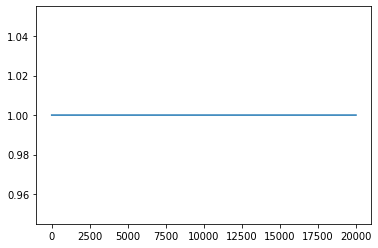

In [126]:
plt.plot(sus[2])
plt.show()

In [127]:
print(sus[2])

[1. 1. 1. ... 1. 1. 1.]


In [128]:
config_0 = config_gen(4)
sus = mc_susceptibility(config_0,beta_c,0,10000,burn_in=10000)

susceptibility:  0.3364235090506503
error:  0.0013164192943668045
rejection: 1563


susceptibility:  0.0
error:  0.0
rejection: 10000


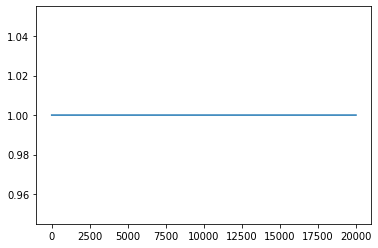

[1. 1. 1. ... 1. 1. 1.]


In [129]:
config_0 = config_gen(32)
sus = mc_susceptibility(config_0,beta_c,0,10000,burn_in=10000)

plt.plot(sus[2])
plt.show()

print(sus[2])